# Как найти стог сена в иголке? Практический проект по построению системы поиска аномалий

**Цель:** В этом домашнем задании вам предстоит настроить систему по поиску аномалий в банковских транзакциях. Мало того, что аномальных значений в данных меньше одного процента, так еще и переменные анонимизированные и представляют собой первые 28 главных компонент, полученных после PCA преобразования оригинальных данных (о которых мы ничего не знаем). Смогут ли бравые unsupervised методы справится с такой задачей? Можно ли работать в таких условиях? Кто подставил кролика Роджера? Ответы на некоторые их этих вопросов вы узнаете после выполнения задания :)

1. Скачайте датасет с [https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv](https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv) и
2. Проведите небольшой EDA (гистограммы и описательные статистики - обязательно)
3. Воспользуйтесь процентом аномалий, подсчитанным по переменной Class, как "экспертной оценкой" загрязненности нашего датасета
4. Попробуйте построить различные модели и алгоритмы, разобранные на занятии, используя полученную экспертную оценку для настройки параметров
5. Воспользуйтесь стандартными методами оценки качества бинарной классификации (особенно хорошо подойдёт classification report и confusion matrix), и, используя предсказания моделей и переменную Class, проверьте, действительно ли модели справляются со своей задачей и на сколько хорошо они это делают
6. При помощи tSNE и/или UMAP, постройте сжатое представление исходных данных и проверьте, действительно ли аномалии лежат достаточно далеко от основной массы точек

## Критерии оценки

- Базовый EDA - 2 балла
- Построены различные алгоритмы по поиску аномалий (основанные на расстояниях, плотностях и используя модели) - 5 баллов
- Проверка качества и отображение на сжатое пространство - 3 балла

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

## 1 Загрузка данных

Загружаем данные из датасета по выдаче кредитов ([https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv](https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv)). Все колонки анонимизированные, крому `Time` и `Amount`.
- Time - количество секунд между каждой транзакцией и первой транзакцией
- Amount - Сумма транзакции
- Class - Мошенническая транзакция или нет

In [2]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Получение базовых статистик датасета: средние, медиана, персентили

In [4]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 2 EDA

Сперва проверим, есть ли пропуски в данных.

In [5]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Пропусков нет, может переходить к последовательному анализу колонок.

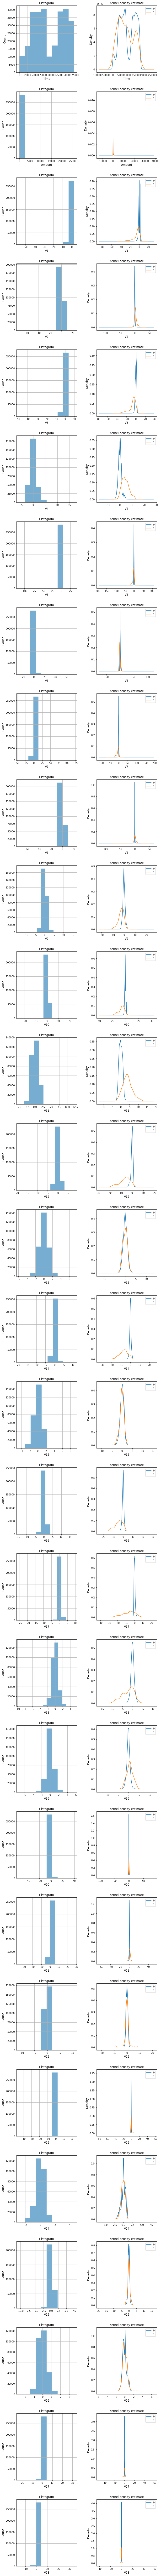

In [6]:
# Список колонок для построения графиков
columns = ['Time', 'Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
           'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
           'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']

# Группировка по целевой переменной
data_grouped = data.groupby("Class")

# Создадим окружение для графиков, для каждой колонки два стобца
fig, axs = plt.subplots(nrows=len(columns), ncols=2, figsize=(10,150))

for index, column in enumerate(columns):
    # В первом столбце отобразим гистограмму, alpha=0.6 позволяет увидеть наложение
    data_grouped[column].hist(alpha=0.6, ax=axs[index, 0])
    axs[index, 0].set_title('Histogram')
    axs[index, 0].set_xlabel(column, fontsize=12)
    axs[index, 0].set_ylabel('Count', fontsize=12)

    # Во втором столбце отобразим график сглаженной плотности распределения на основе ядерной оценки
    data_grouped[column].plot(kind='kde', ax=axs[index, 1])
    axs[index, 1].set_title('Kernel density estimate')
    axs[index, 1].set_xlabel(column, fontsize=12)
    axs[index, 1].set_ylabel('Density', fontsize=12)
    axs[index, 1].legend()

plt.tight_layout(pad=3.0)
plt.show()

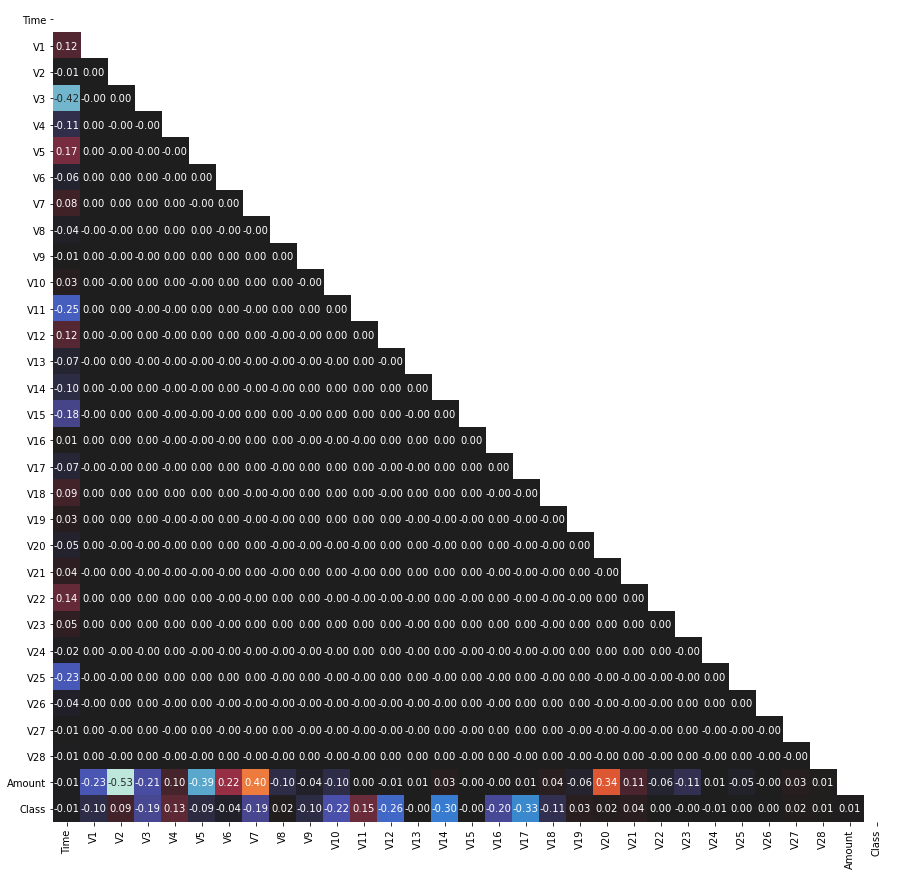

In [7]:
plt.figure(figsize=(15,15))

corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

## 3 Экспертная оценка аномалий

In [8]:
data.loc[data['Class'] == 1].shape[0]

492

In [9]:
outliers_percentage_actual = data.loc[data['Class'] == 1].shape[0] / data.shape[0] *100
outliers_percentage_actual

0.1727485630620034

## 4 Поиск аномалий
Сперва отобразим датасет на двумерной плоскости, используя уменьшение размерности.

In [10]:
from sklearn.preprocessing import RobustScaler

data_features = data.drop('Class', axis=1)
scaler = RobustScaler()
data_scaled = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)
data_features_scaled = data_scaled.copy()
data_scaled['Class'] = data['Class']

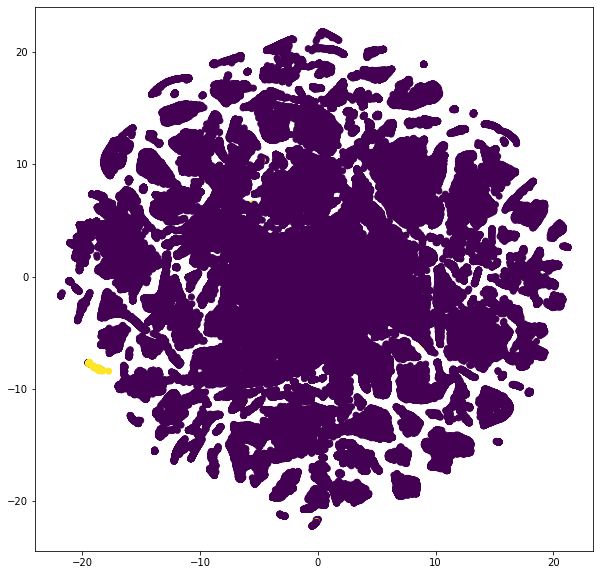

In [11]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(perplexity=50, n_jobs=-1)
tsne_transformed = tsne.fit_transform(data_scaled)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=data['Class'])

Создадим функцию, которая по заданной функции поиска аномалий будет собирать все аномалии, а также функцию, которая будет подсчитывать их процент.

In [12]:
def get_outliers(data, function, threshold=3):
    outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')
    
    for column in data.columns:
        anomalies = function(data, column, threshold=threshold)       
        outliers[anomalies[anomalies].index] = True        
    
    return outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))  

### 4.1 Простейшие методы
#### 4.1.1 3-сигмы

In [13]:
def outlier_std(data, column, threshold=3):
    mean = data[column].mean()
    std = data[column].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[column]>up_bound, data[column]<low_bound], axis=1).any(1)
    return anomalies

In [14]:
std_outliers = get_outliers(data_features, function=outlier_std)
anomalies_report(std_outliers)

Total number of outliers: 37816
Percentage of outliers:   13.28


#### 4.1.2 Межквартильное отклонение

Сперва построим `box-plots` по каждому признаку.

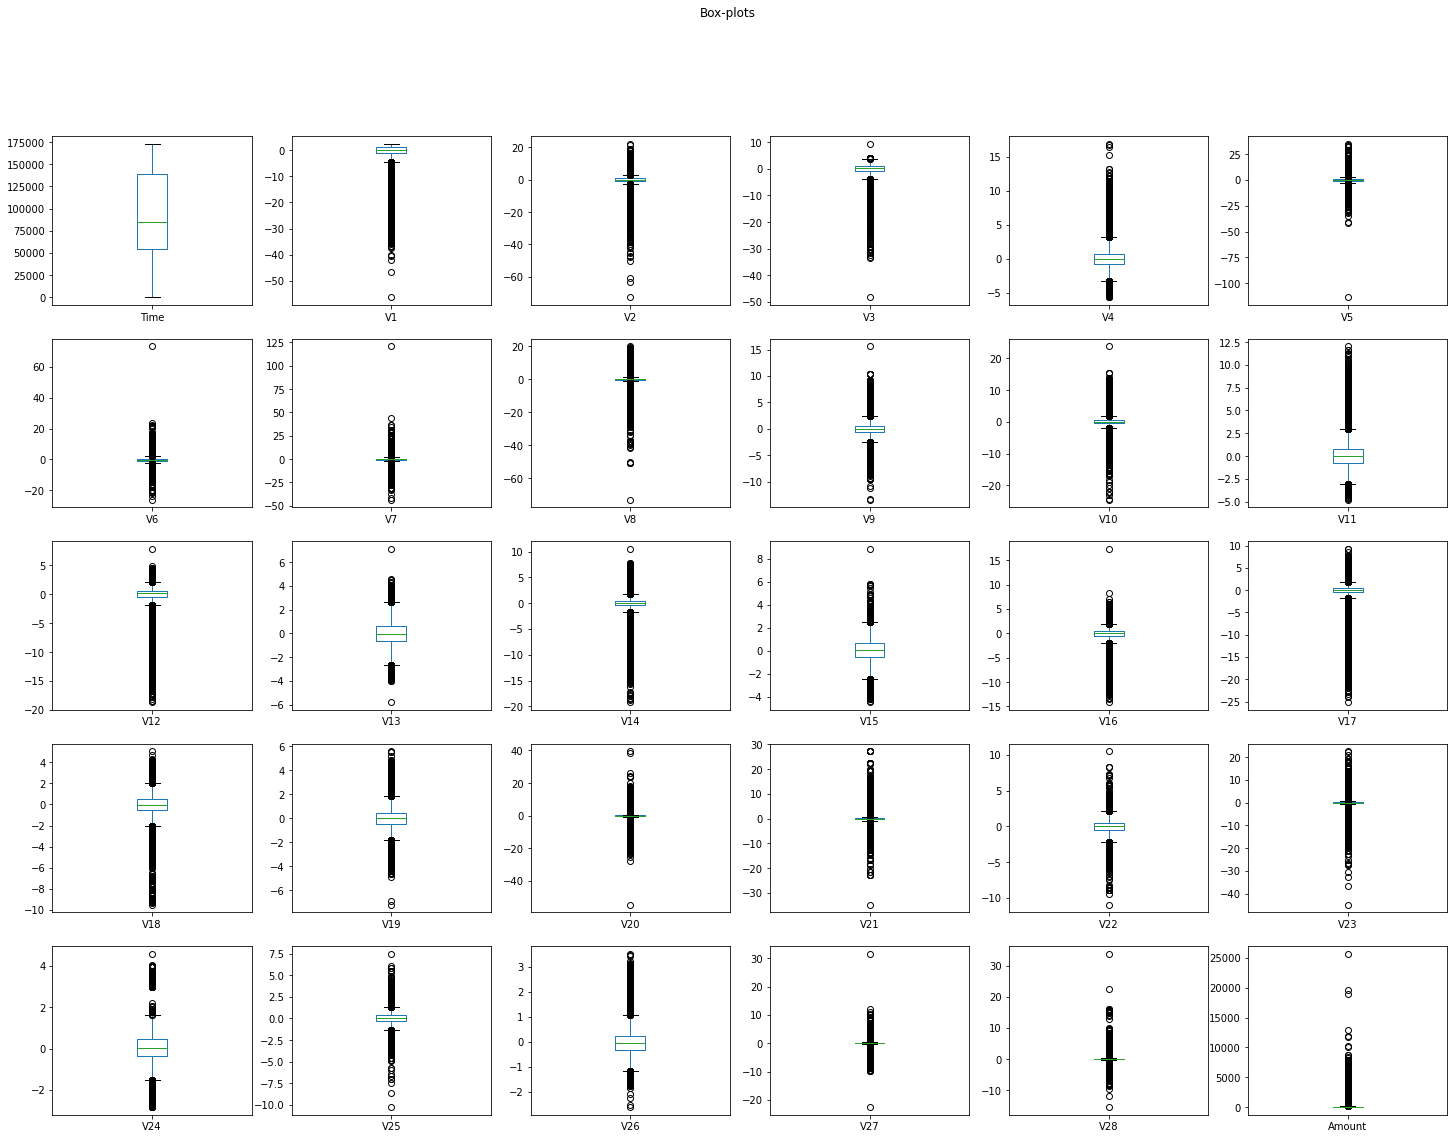

In [15]:
fig, axes = plt.subplots(5, 6, figsize=(25, 18))
fig.suptitle('Box-plots')

row=0
col=0

for ax, feature in enumerate(data_features):
    data_features[feature].plot.box(ax=axes[row, col])
    col+=1
    if col > 5:
        row+=1
        col=0

Как видно, по некоторым признаком хорошо заметны наличие аномалий (например, `V6`, `V7`)

In [16]:
def outlier_iqr(data, column, threshold=3):
    IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
    up_bound = data[column].quantile(0.75) + (IQR * threshold)
    low_bound = data[column].quantile(0.25) - (IQR * threshold)
    anomalies = pd.concat([data[column]>up_bound, data[column]<low_bound], axis=1).any(1)
    return anomalies

In [17]:
iqr_outliers = get_outliers(data_features, function=outlier_iqr)
anomalies_report(iqr_outliers)

Total number of outliers: 53336
Percentage of outliers:   18.73


### 4.2 Distance-based
Создадим класс на основе `BaseEstimator`, который будет в качестве результата предсказания будет формировать список аномалий.

In [18]:
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist

class DistanceOutliers(BaseEstimator):
    """
    Distance based outlier detector model
    
    Fit method calculates centroid of training samples and
    using `metric` get distances from centroid to train samples.
    Having distances - we calculate `threshold` based on `percentile`.
    
    Predict method uses `threshold` and `metric` to determine, whether
    distance to sample from centroid is too large -> outlier.
    
    -----------
    Parameters:
    
    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)
        
    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

#### 4.2.1 Euclidean metric

Выше мы уже шкалировали данные, воспользуемся ими, так как имеем дело с расстояниями. А также воспользуемся имеющийся процент аномалий, как "экспертную" оценку.

In [19]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=100-outliers_percentage_actual)
euclidian_model.fit(data_features_scaled)
euclidian_outliers = euclidian_model.predict(data_features_scaled)
anomalies_report(euclidian_outliers)

Total number of outliers: 492
Percentage of outliers:   0.17


Отобразим найденные аномалии на графике.

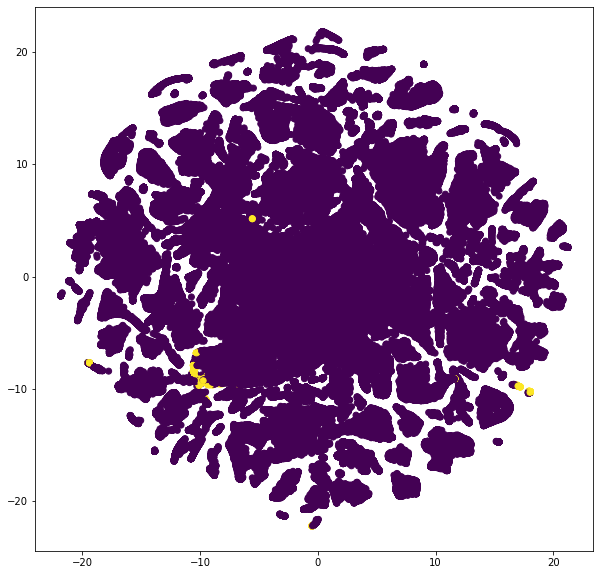

In [20]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=euclidian_outliers);

#### 4.2.2 Cityblock metric

In [21]:
citiblock_model = DistanceOutliers(metric='cityblock', percentile=100-outliers_percentage_actual)
citiblock_model.fit(data_features_scaled)
cityblock_outliers = citiblock_model.predict(data_features_scaled)
anomalies_report(cityblock_outliers)

Total number of outliers: 492
Percentage of outliers:   0.17


Отобразим найденные аномалии на графике.

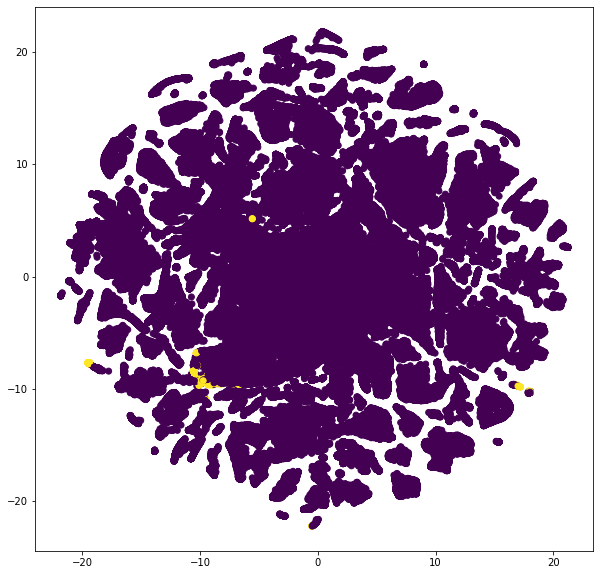

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cityblock_outliers);

### 4.3 Density-based
#### 4.3.1 DBSCAN

In [23]:
"""
threshold = outliers_percentage_actual/100
epsilon = 0.05
outlier_percentage = 1.

epsilons_history = []
clusters_history = []
outliers_history = []

while outlier_percentage > threshold:        
    dbscan = DBSCAN(eps=epsilon)
    dbscan.fit(X)
    clusters = dbscan.labels_
    
    epsilons_history.append(epsilon)
    clusters_history.append(len(np.unique(clusters)) - 1)    
    
    outlier_percentage = sum(clusters == -1) / len(clusters)
    outliers_history.append(outlier_percentage)
    
    epsilon += 0.05   
"""

'\nthreshold = outliers_percentage_actual/100\nepsilon = 0.05\noutlier_percentage = 1.\n\nepsilons_history = []\nclusters_history = []\noutliers_history = []\n\nwhile outlier_percentage > threshold:        \n    dbscan = DBSCAN(eps=epsilon)\n    dbscan.fit(X)\n    clusters = dbscan.labels_\n    \n    epsilons_history.append(epsilon)\n    clusters_history.append(len(np.unique(clusters)) - 1)    \n    \n    outlier_percentage = sum(clusters == -1) / len(clusters)\n    outliers_history.append(outlier_percentage)\n    \n    epsilon += 0.05   \n'

DBSCAN к сожалению, требует слишком много ресурсов на данном датасете. Получилось запустить с epsilon=3.00 и процент аномалий оказался все еще высоким (outlier_percentage=0.26). С более высоким значением epsilon, компьютер уже не смог справиться.

### 4.4 Unsupervised model-based

#### 4.4.1 One-Class SVM

In [24]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=outliers_percentage_actual/100, gamma='auto')
one_class_svm.fit(data_features_scaled)
svm_outliers = one_class_svm.predict(data_features_scaled)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

In [25]:
anomalies_report(svm_outliers)

Total number of outliers: 2751
Percentage of outliers:   0.97


#### 4.4.2 Isolation Forest 

In [26]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination=outliers_percentage_actual/100, 
                                   max_features=1.0, bootstrap=True, n_jobs=-1)
isolation_forest.fit(data_features_scaled)

isolation_outliers = isolation_forest.predict(data_features_scaled)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

In [27]:
anomalies_report(isolation_outliers)

Total number of outliers: 491
Percentage of outliers:   0.17


## 5 Проверка качества моделей

Создадим итоговую таблицу с результатами проверки качества наших моделей поиска аномалий. Первые три строки отображают метрики `precision`,  `recall`, `f1-score` (`accuracy` в нашем случае несбалансированных классов пользы не приносит). Последние 3 строки показывает количество верно классифицированных объектов, а также количество ложно-отрицательных и ложно-положительных объектов.

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

outliers_quality = pd.DataFrame({"metric":["Precision", "Recall", "F1-score", "TP", "FN", "FP"]})
outliers_quality.set_index("metric")

""
metric
Precision
Recall
F1-score
TP
FN
FP


In [29]:
def fill_report(outliers_quality, y_true, y_pred, model_name):
    report = precision_recall_fscore_support(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    outliers_quality[model_name] = [report[0][1], report[1][1], report[2][1],
                                    matrix[1][1], matrix[1][0], matrix[0][1]]    

In [30]:
fill_report(outliers_quality, data['Class'], std_outliers, '3-sigm')
fill_report(outliers_quality, data['Class'], iqr_outliers, 'IQR')
fill_report(outliers_quality, data['Class'], euclidian_outliers, 'Euclidian')
fill_report(outliers_quality, data['Class'], cityblock_outliers, 'Cityblock')
fill_report(outliers_quality, data['Class'], svm_outliers, 'SVM')
fill_report(outliers_quality, data['Class'], isolation_outliers, 'Isolation')

outliers_quality

,metric,3-sigm,IQR,Euclidian,Cityblock,SVM,Isolation
0,Precision,0.011741,0.008475,0.036585,0.227642,0.047619,0.224033
1,Recall,0.902439,0.918699,0.036585,0.227642,0.266260,0.223577
2,F1-score,0.023181,0.016794,0.036585,0.227642,0.080789,0.223805
3,TP,444.000000,452.000000,18.000000,112.000000,131.000000,110.000000
4,FN,48.000000,40.000000,474.000000,380.000000,361.000000,382.000000
5,FP,37372.000000,52884.000000,474.000000,380.000000,2620.000000,381.000000


Как видно из итогового отчета, простые методы хорошо справляются с поиском аномалий, но при это захватывают слишком много лишних объектов.
Модели, основанные на расстоянии показали себя по разному (`Cityblock` чуть лучше справился), но все процент правильно найденных аномалий достаточно мал. Похожую картину наблюдаем и в модели `Isolation Forest`. `SVM` нашел верно большее количество аномалий, но при этом пометил и большое количество ложно положительных объектов.